# Video Game Sales Analysis
## A Machine Learning Project
Jordan Perrin   199076727

1. I’ll begin by laying out the problem that I decided to solve through machine learning. There is a huge wealth of data out there about video games – video game sales, video game popularity, the best genres, etc. However, I wanted to get to the bottom of the matter about what is truly the best-selling type of video game, and to do that I believe machine learning is the perfect method, as it allows a massive amount of data to be read, understood and fed back to you, without any sort of bias. This would also be incredibly useful for development companies to use in terms of deciding what they want to make next and get an estimate of how popular their next game could be, given some statistics.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as nm
import pickle
from scipy import stats
from scipy.stats import norm, skew 
from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

2. Here we import the data and display it in different ways, just to check that it loaded okay and to see what data we're dealing with.

In [2]:
data = pd.read_csv('vgsales.csv')
data.head

<bound method NDFrame.head of         Rank                                              Name Platform  \
0          1                                        Wii Sports      Wii   
1          2                                 Super Mario Bros.      NES   
2          3                                    Mario Kart Wii      Wii   
3          4                                 Wii Sports Resort      Wii   
4          5                          Pokemon Red/Pokemon Blue       GB   
...      ...                                               ...      ...   
16593  16596                Woody Woodpecker in Crazy Castle 5      GBA   
16594  16597                     Men in Black II: Alien Escape       GC   
16595  16598  SCORE International Baja 1000: The Official Game      PS2   
16596  16599                                        Know How 2       DS   
16597  16600                                  Spirits & Spells      GBA   

         Year         Genre   Publisher  NA_Sales  EU_Sales  JP_Sales

In [3]:
data.shape

(16598, 11)

In [4]:
data['Genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [5]:
data['Platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       '3DS', 'PS4', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne', 'GC',
       'WiiU', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [6]:
data['Publisher'].unique()

array(['Nintendo', 'Microsoft Game Studios', 'Take-Two Interactive',
       'Sony Computer Entertainment', 'Activision', 'Ubisoft',
       'Bethesda Softworks', 'Electronic Arts', 'Sega', 'SquareSoft',
       'Atari', '505 Games', 'Capcom', 'GT Interactive',
       'Konami Digital Entertainment',
       'Sony Computer Entertainment Europe', 'Square Enix', 'LucasArts',
       'Virgin Interactive', 'Warner Bros. Interactive Entertainment',
       'Universal Interactive', 'Eidos Interactive', 'RedOctane',
       'Vivendi Games', 'Enix Corporation', 'Namco Bandai Games',
       'Palcom', 'Hasbro Interactive', 'THQ', 'Fox Interactive',
       'Acclaim Entertainment', 'MTV Games', 'Disney Interactive Studios',
       nan, 'Majesco Entertainment', 'Codemasters', 'Red Orb', 'Level 5',
       'Arena Entertainment', 'Midway Games', 'JVC', 'Deep Silver',
       '989 Studios', 'NCSoft', 'UEP Systems', 'Parker Bros.', 'Maxis',
       'Imagic', 'Tecmo Koei', 'Valve Software', 'ASCII Entertainment',


3. Next, we'll check for any blank fields, so we can clean them.

In [7]:
data.isna().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

There are 271 Blank fields in year, and 58 in Publisher. However, these two columns are going to be unnecessary for us to clean, as we're going to remove them anyway. I don't believe the year the game released and the game publisher will weigh too heavily on what we're looking for, so we can drop them, as well as the game name, it's rank in the list, and the sales values that come together to make up the global sales, as none of them will effect what we're looking for.

In [8]:
data = data.drop(columns = ['Name','Rank','Year', 'Publisher'], axis=1)
data.shape

(16598, 7)

In [9]:
data.head

<bound method NDFrame.head of       Platform         Genre  NA_Sales  EU_Sales  JP_Sales  Other_Sales  \
0          Wii        Sports     41.49     29.02      3.77         8.46   
1          NES      Platform     29.08      3.58      6.81         0.77   
2          Wii        Racing     15.85     12.88      3.79         3.31   
3          Wii        Sports     15.75     11.01      3.28         2.96   
4           GB  Role-Playing     11.27      8.89     10.22         1.00   
...        ...           ...       ...       ...       ...          ...   
16593      GBA      Platform      0.01      0.00      0.00         0.00   
16594       GC       Shooter      0.01      0.00      0.00         0.00   
16595      PS2        Racing      0.00      0.00      0.00         0.00   
16596       DS        Puzzle      0.00      0.01      0.00         0.00   
16597      GBA      Platform      0.01      0.00      0.00         0.00   

       Global_Sales  
0             82.74  
1             40.24  
2  

We're also going to remove the data for the platforms apart from the most recent ones, as not only has gaming come a long way in popularity and demographic, so the data from the "old" consoles won't be as up to date and accurate as the recent generation of consoles, but it also means the data will be easier to practice on.

In [10]:
data['Platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       '3DS', 'PS4', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne', 'GC',
       'WiiU', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

We will check again for null or na values, just to make sure we haven't  missed anything.

In [11]:
data.isna().sum()

Platform        0
Genre           0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

In [12]:
data.isnull().sum()

Platform        0
Genre           0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

Checking the data once again.

In [13]:
data.head

<bound method NDFrame.head of       Platform         Genre  NA_Sales  EU_Sales  JP_Sales  Other_Sales  \
0          Wii        Sports     41.49     29.02      3.77         8.46   
1          NES      Platform     29.08      3.58      6.81         0.77   
2          Wii        Racing     15.85     12.88      3.79         3.31   
3          Wii        Sports     15.75     11.01      3.28         2.96   
4           GB  Role-Playing     11.27      8.89     10.22         1.00   
...        ...           ...       ...       ...       ...          ...   
16593      GBA      Platform      0.01      0.00      0.00         0.00   
16594       GC       Shooter      0.01      0.00      0.00         0.00   
16595      PS2        Racing      0.00      0.00      0.00         0.00   
16596       DS        Puzzle      0.00      0.01      0.00         0.00   
16597      GBA      Platform      0.01      0.00      0.00         0.00   

       Global_Sales  
0             82.74  
1             40.24  
2  

Here we plot the data to check for outliers, using a scatter graph of the genre against the global sales.

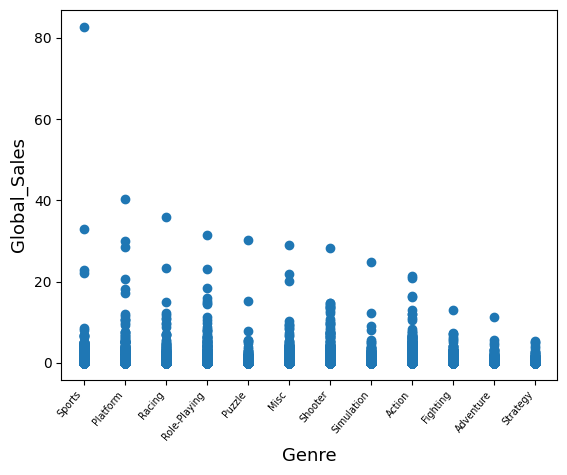

In [14]:
fig, ax = plt.subplots()
plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='right', fontsize='x-small')
ax.scatter(x = data['Genre'], y = data['Global_Sales'])
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Genre', fontsize=13)
plt.show()

There's a very clear outlier to the rest of the games (it's wii sports by the way, so no wonder) that skews the data, so we'll remove that and have more normalized data (sorry wii sports, bowling was pretty good)

In [15]:
data = data.drop(data[(data['Genre']=='Sports') & (data['Global_Sales']>80)].index)

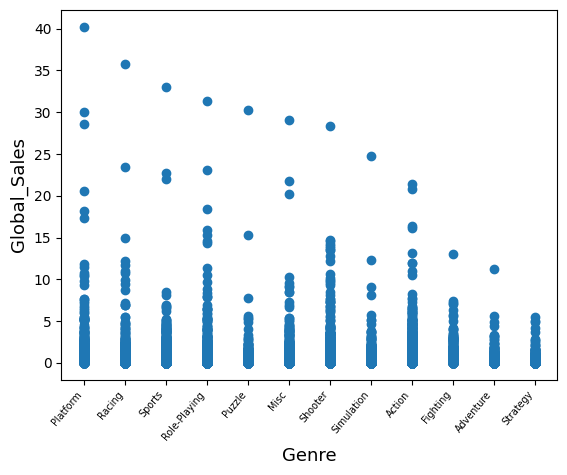

In [16]:
fig, ax = plt.subplots()
plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='right', fontsize='x-small')
ax.scatter(x = data['Genre'], y = data['Global_Sales'])
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Genre', fontsize=13)
plt.show()

We do the same for the Global Sales against the Platform, and our results are pretty standardized, especially now that Wii Sports has already been removed.

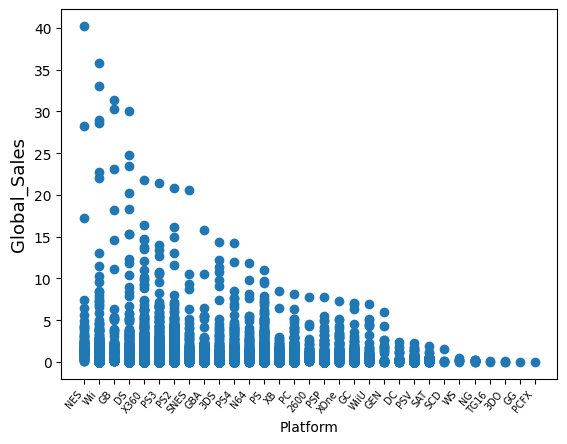

In [17]:
fig, ax = plt.subplots()
plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='right', fontsize='x-small')
ax.scatter(x = data['Platform'], y = data['Global_Sales'])
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Platform', fontsize=10)
plt.show()

Here we can see we have some outliers on the Wii, which we will remove to create a much more standardized reading.

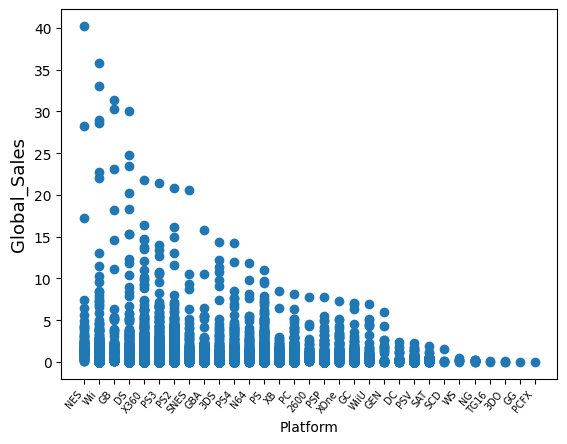

In [18]:
fig, ax = plt.subplots()
plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='right', fontsize='x-small')
ax.scatter(x = data['Platform'], y = data['Global_Sales'])
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Platform', fontsize=10)
plt.show()

Now we check what data types we have in our data, so we can change and clean it as necessary so that the machine can read it.

In [19]:
float64_cols = ['float64']
float64_lst = list(data.select_dtypes(include=float64_cols).columns)
print("Number of float64 columns: ", len(float64_lst))
print("Names of columns: ", float64_lst)

Number of float64 columns:  5
Names of columns:  ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']


In [20]:
objects_cols = ['object']
objects_lst = list(data.select_dtypes(include=objects_cols).columns)
print("Number of categorical columns: ", len(objects_lst))
print("Names of columns: ", objects_lst)

Number of categorical columns:  2
Names of columns:  ['Platform', 'Genre']


In [21]:
int64_cols = ['int64']
int64_lst = list(data.select_dtypes(include=int64_cols).columns)
print("Number of numerical columns: ", len(int64_lst))
print("Names of columns: ", int64_lst)

Number of numerical columns:  0
Names of columns:  []


As we have 2 categorical data columns, we need to encode them to make sure that the machine can actually read them, as they're currently just labels instead of any readable numerical data. We can also first display the unique platforms and genres, so that we can match them up later if we want to test a certain input.

In [22]:
data['Platform'].unique()

array(['NES', 'Wii', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       '3DS', 'PS4', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne', 'GC',
       'WiiU', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [23]:
data['Genre'].unique()

array(['Platform', 'Racing', 'Sports', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [24]:
le = LabelEncoder()
data.Platform = le.fit_transform(data.Platform)
data.Genre = le.fit_transform(data.Genre)

Once we've encoded it, we can check the unique values again, and as you can see, the values are no longer X360, Wii, Wii U, etc. but instead it's been transformed into numerical data, that the machine can read.

In [25]:
data['Platform'].unique()

array([11, 26,  5,  4, 28, 17, 16, 23,  6,  2, 18, 10, 15, 29, 13,  0, 19,
       30,  7, 27,  8,  3, 20, 21, 22, 25, 12, 24,  1,  9, 14])

In [26]:
data['Genre'].unique()

array([ 4,  6, 10,  7,  5,  3,  8,  9,  0,  2,  1, 11])

Now that this is done, we can move onto calculating the skew of the data, which basically is how far to the left/right of the average the data skews.

In [27]:
data['Global_Sales'].skew()

11.217078679154975

In [28]:
data['JP_Sales'].skew()

11.250346409124097

In [29]:
data['EU_Sales'].skew()

10.61765441955855

In [30]:
data['NA_Sales'].skew()

14.196793548692366

In [31]:
data['Other_Sales'].skew()

22.88153332387653

In [32]:
data.skew().sort_values(ascending=False)

Other_Sales     22.881533
NA_Sales        14.196794
JP_Sales        11.250346
Global_Sales    11.217079
EU_Sales        10.617654
Genre            0.068595
Platform        -0.031125
dtype: float64

In [33]:
data['JP_Sales_skew'] = nm.sqrt(data['JP_Sales'])
data['JP_Sales_skew'].skew()

3.2317359669692824

In [34]:
data['EU_Sales_skew'] = nm.sqrt(data['EU_Sales'])
data['EU_Sales_skew'].skew()

2.674102050540048

In [35]:
data['NA_Sales_skew'] = nm.sqrt(data['NA_Sales'])
data['NA_Sales_skew'].skew()

2.4992635776333656

In [36]:
data['Other_Sales_skew'] = nm.sqrt(data['Other_Sales'])
data['Other_Sales_skew'].skew()

3.1128291077588237

In [37]:
data['Global_Sales_skew'] = nm.sqrt(data['Global_Sales'])
data['Global_Sales_skew'].skew()

3.071466319358874

In [38]:
data = data.drop(['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales'],axis = 1)

Normalizing the skew in this data isn't as important as it would be for other kinds of data, as the range of sales does not normalize well, and isn't important to figuring out how genre/platform effects the sales. 

Next, we choose the global sales value to be the target of the features, basically choosing global sales to be what we try to estimate by using the genre and platform.

In [39]:
target= 'Global_Sales_skew'
X = data.drop(target,axis=1)
y = data[target]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16597 entries, 1 to 16597
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Platform          16597 non-null  int32  
 1   Genre             16597 non-null  int32  
 2   JP_Sales_skew     16597 non-null  float64
 3   EU_Sales_skew     16597 non-null  float64
 4   NA_Sales_skew     16597 non-null  float64
 5   Other_Sales_skew  16597 non-null  float64
dtypes: float64(4), int32(2)
memory usage: 648.4 KB


Printing the shape of X and y to check that it worked properly.

In [40]:
X.shape, y.shape

((16597, 6), (16597,))

Here we need to reshape y so that global sales fits with the rest of the data in x.

In [41]:
y = y.values.reshape(-1,1)
X.shape, y.shape

((16597, 6), (16597, 1))

4. For our models, we will test using Linear Regression, Lasso Regression, and Random Forest Regressor.

Linear regression attempts to model the relationship between variables by fitting it to a linear equation. One variable is the dependent variable, and the other is the variable what you want to reach based on the dependent variables. This works well for our project because the variable we want to reach is the global sales value, and that can depend on the other variables in the dataset.

Lasso regression is a form of linear regression, and attempts to get rid of irrelevant parameters, assisting in the concentration of selection and normalizes the model for more accurate data.

Random forest regressor fits a number of classifying decision trees to various amples of the dataset and improves accuracy and control by using averages.

5. Now, we split the dataset into training and test data. We use an 80-20 split, so that sample sizes on both sides are big enough to draw from. We also check the shape of the new parts to make sure it all looks okay. I tried other values to split the data, but 80% lead to the most accurate results.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13277, 6), (3320, 6), (13277, 1), (3320, 1))

First we'll define our Kfold value for cross validation later, to test the machines ability to predict  data that wasn't used in the construction of the model.

In [43]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

First, we'll test linear regression and see how the model manages with that, and if it scores high on accuracy across dataset matches.

In [44]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9745897187217948

Accuracy of the training data itself

In [45]:
model.score(X_train, y_train)

0.975300224625098

Accuracy of the test data itself

In [46]:
model.score(X_test, y_test)

0.9745897187217948

Using our KFold values from earlier, we can get the cross validation scores.

In [47]:
lg_scores = -1 * cross_val_score(model, 
                                 X_train, 
                                 y_train, 
                                 cv=cv, 
                                 scoring='neg_root_mean_squared_error')
lg_scores

array([0.08228124, 0.07929391, 0.07345992, 0.06942246, 0.07191032,
       0.07648677, 0.0716953 , 0.06981173, 0.07358123, 0.07733632])

With these scores, we can then average them out to get a more completely accurate depiction of how it performs.

In [48]:
lg_score_train = nm.mean(lg_scores)
lg_score_train

0.07452791907982804

With all this done, we can now get our results for Linear Regression's accuracy.

In [49]:
y_predicted = model.predict(X_test)

In [50]:
rg = r2_score(y_test,y_predicted)*100
print("The accuracy is: {}".format(rg))

The accuracy is: 97.45897187217948


We then move on to lasso regression, and can check the accuracy of the training data using it.

In [51]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train,y_train)
Lasso(alpha=0.1)
clf.score(X_train,y_train)

0.47462520184480417

We then check the accuracy of the test data.

In [52]:
y_predicted1 = clf.predict(X_test)
lg = r2_score(y_test,y_predicted1)*100
lg

47.5064890085524

Using our KFold from earlier, we again use it to cross validate using Lasso Regression, and then get the mean of the results from that.

In [53]:
Nn_scores = -1 * cross_val_score(clf, 
                                    X_train, 
                                    y_train, 
                                    cv=cv, 
                                    scoring='neg_root_mean_squared_error')
Nn_scores

array([0.33959757, 0.33564402, 0.33512176, 0.35858605, 0.33472361,
       0.33992107, 0.34628497, 0.33626731, 0.36590634, 0.34236744])

In [54]:
Nn_score_train = nm.mean(Nn_scores)
Nn_score_train

0.34344201477612374

In [55]:
lg = r2_score(y_test,y_predicted)*100
print("The accuracy is: {}".format(lg))

The accuracy is: 97.45897187217948


Finally, we move on to Random Forest Regressor, and check the scoring of the training data again.

In [56]:
RFReg = RandomForestRegressor(max_depth=2, random_state=0)
RFReg.fit(X_train, y_train)
RFReg.score(X_train, y_train)

C:\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.7764878438355911

Once again, we use our KFold from earlier to get the cross validation scores, this time for Random Forest Regressor.

In [57]:
Dta_scores = -1 * cross_val_score(RFReg, 
                                    X_train, 
                                    y_train, 
                                    cv=cv, 
                                    scoring='neg_root_mean_squared_error')
Dta_scores

C:\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(esti

array([0.22488934, 0.22428893, 0.22413748, 0.20785929, 0.22164593,
       0.2315729 , 0.22369379, 0.21450739, 0.24035355, 0.22904395])

Again, we calculate the mean from the results we got from using cross validation.

In [58]:
Dta_score_train = nm.mean(Dta_scores)
Dta_score_train

0.22419925637841512

In [59]:
y_predicted = RFReg.predict(X_test)

In [60]:
r_acc = r2_score(y_test, y_predicted)*100
print("The accuracy is {} %".format(r_acc))

The accuracy is 75.96666111411197 %


In [61]:
cal_metric=pd.DataFrame([rg,lg,r_acc],columns=["Global_Sales"])
cal_metric.index=['Linear Regression',
                  'Lasso Regression','Random forest Regressor']
cal_metric

,Global_Sales
Linear Regression,97.458972
Lasso Regression,97.458972
Random forest Regressor,75.966661


From these results, you can see that using Linear Regression or Lasso Regression is quite a lot better than using Random forest Regressor. So, we will save our model with that, and test it.

In [62]:
pickle.dump(model, open('VGSales_LinearRegression.pkl', 'wb'))

In [63]:
def model_predict(features):
    pickled_model = pickle.load(open('VGSales_LinearRegression.pkl', 'rb'))
    Global_Sales = str(list(pickled_model.predict(features)))

    return str(f'The sales in millions would be: {Global_Sales}')

Platform 3 would be the Wii, and Genre 6 would be Racing, so let's see how a Racing wii game could potentially perform.

In [70]:
Platform = 1
Genre = 6
NA_Sales_skew = 4.2
EU_Sales_skew = 3.78
JP_Sales_skew = 0.8
Other_Sales_skew = 3.2

In [71]:
model_predict([[Platform, Genre, NA_Sales_skew, EU_Sales_skew, JP_Sales_skew, Other_Sales_skew]])

'The sales in millions would be: [array([6.30479612])]'

And there you have it, we have a program that can estimate the performance of a certain genre/platform combo and how well it performs in certain regions, potentially informing game developers what would be the most profitable return on their investments.